In [16]:
from pytransit import MandelAgol
import subprocess
import timeit 
import random
import glob, os
import sys 
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np

from astropy.stats import BoxLeastSquares
import lightkurve as lk

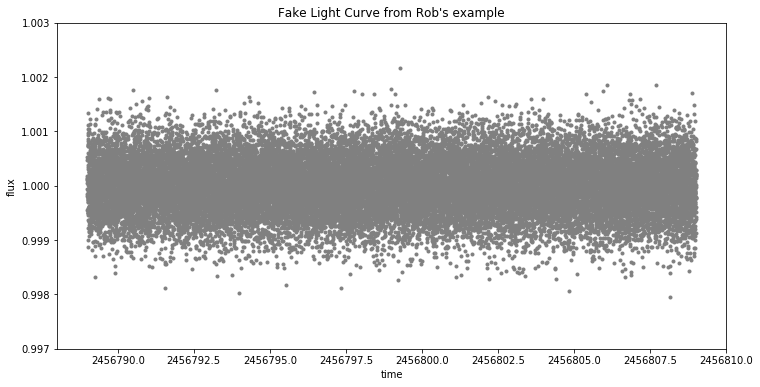

In [2]:
ndays = 20
pts_per_day = 24*60 #points per minute 
scatter_frac = 0.0005  # 0.05% ~ 0.6 mmag

dummy_jd = 2456789.0 + np.linspace(0.0, ndays, ndays*pts_per_day) #start, stop, stepsize
dummy_jd += np.random.randn(dummy_jd.size) / 500.0 # makes time sampling irregular, if desired
# np.random.randn samples within a gaussian distribution of mean and variances = 1

# .size prints number of elements (like len()?)

dummy_flux = 1.0 + np.random.randn(dummy_jd.size) * scatter_frac
dummy_err = np.ones_like(dummy_flux) * scatter_frac
#np.ones returns array of ones given a size

plt.figure(1,figsize=(12,6))
ax0 = plt.gca()
ax0.get_xaxis().get_major_formatter().set_useOffset(False) #This removes sci. notation
ax0.get_yaxis().get_major_formatter().set_useOffset(False)

ax0.plot(dummy_jd, dummy_flux, marker='.', linestyle='none', color='grey')
ax0.set_xlabel("time")
ax0.set_ylabel("flux")
plt.xlim(np.min(dummy_jd)-1, np.max(dummy_jd)+1)
plt.ylim(0.997, 1.003)
ax0.set_title("Fake Light Curve from Rob's example")
plt.show()

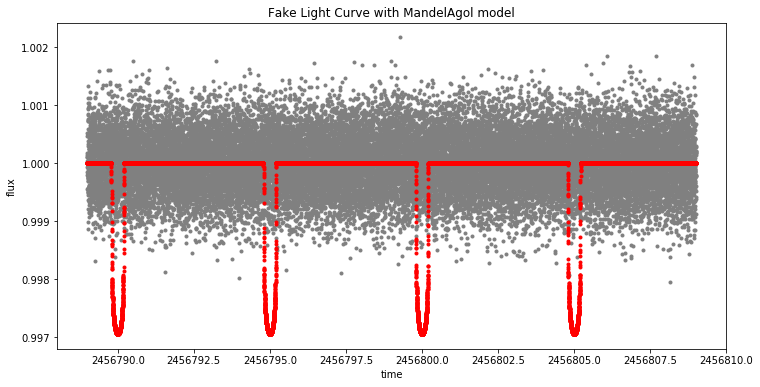

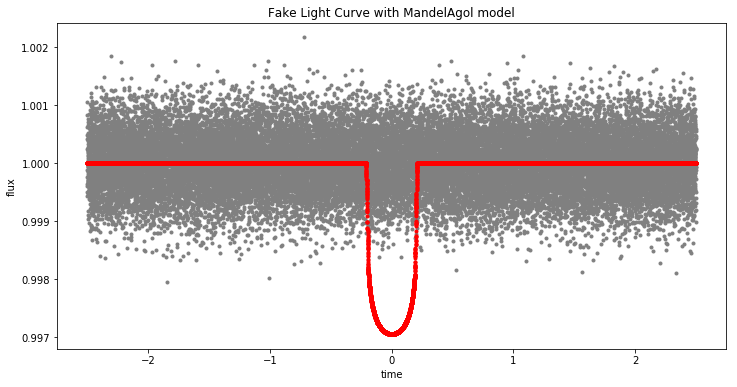

In [12]:
t = dummy_jd
k = 0.05 # R_planet / R_star
t0 = 0.0 # transit center time?
#t0 = np.mean(dummy_jd) # transit center time?
# p = 19.99988 # orbital period (days)
p = 5.0
a = 4 # semi-major axis
i = 0.5*np.pi # inclination
e =0.0 #eccentricity
w = 0.5*np.pi # the argument of periastron
u = [0.3,0.3] # limb darkening coeff.

m = MandelAgol()
f = m.evaluate(t, k, u, t0, p, a, i, e, w)


plt.figure(1,figsize=(12,6))
ax0 = plt.gca()
ax0.get_xaxis().get_major_formatter().set_useOffset(False) #This removes sci. notation
ax0.get_yaxis().get_major_formatter().set_useOffset(False)

#phase folding
foldtime = ((t - t0  + p/2.0) % p)- p/2.0
#((t - T_0D + PeriodD/2.0) % PeriodD) - PeriodD/2.0


# #### with a
plt.figure(1,figsize=(12,6))
ax0 = plt.gca()
ax0.get_xaxis().get_major_formatter().set_useOffset(False) #This removes sci. notation
ax0.get_yaxis().get_major_formatter().set_useOffset(False)

ax0.plot(foldtime, dummy_flux, color='grey', marker='.', linestyle='none')
ax0.plot(foldtime, f, color='red', marker='.', linestyle='none')
ax0.set_xlabel("time")
ax0.set_ylabel("flux")

ax0.set_title("Fake Light Curve with MandelAgol model")
plt.show()

In [9]:
print (f.flatten())

[1. 1. 1. ... 1. 1. 1.]


In [10]:
import time
start=time.time()


print(shape(f),shape(dummy_flux))
model_subtracted_data = f.flatten() - dummy_flux + 1
end=time.time()

runtime=end-start;print(runtime)

print("")
print(shape(model_subtracted_data))


(28800, 1) (28800,)
0.6665000915527344

(28800,)


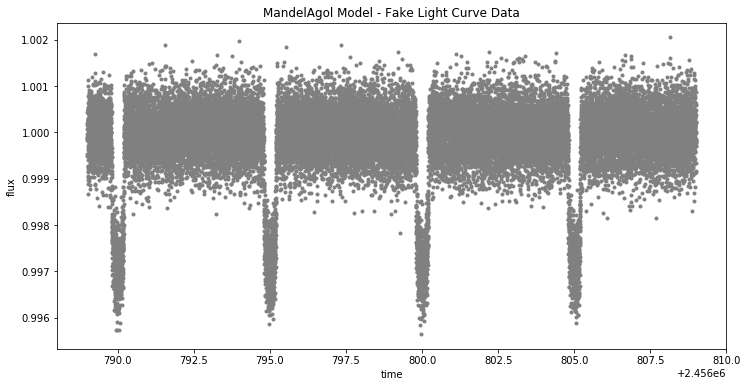

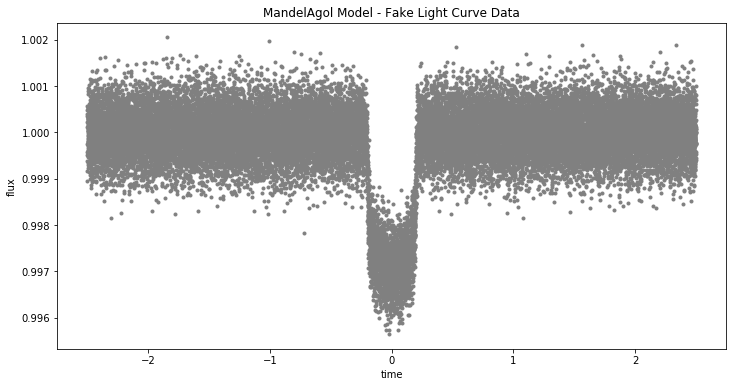

0.5673232078552246


In [13]:
start=time.time()
plt.figure(figsize=(12,6))
plt.plot(dummy_jd, model_subtracted_data,color='grey', marker='.', linestyle='none')
plt.xlabel("time")
plt.ylabel("flux")
plt.title("MandelAgol Model - Fake Light Curve Data")
plt.show()


plt.figure(figsize=(12,6))
plt.plot(foldtime, model_subtracted_data,color='grey', marker='.', linestyle='none')
plt.xlabel("time")
plt.ylabel("flux")
plt.title("MandelAgol Model - Fake Light Curve Data")
plt.show()
end=time.time()

runtime=end-start;print(runtime)

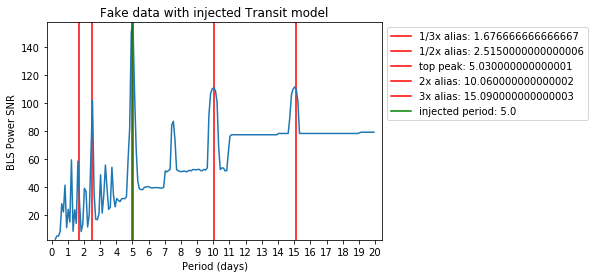

Best BLS Period 5.030000000000001


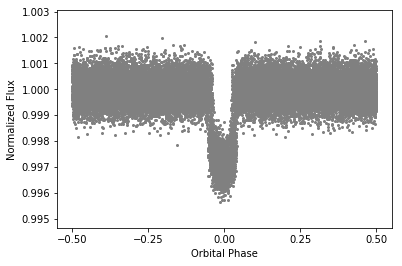

In [32]:
lc = lk.LightCurve(dummy_jd,model_subtracted_data,dummy_err)

bls = BoxLeastSquares(lc.time, lc.flux, lc.flux_err)

periods = np.arange(0.23, (max(lc.time)-min(lc.time)), 0.1)
durations = np.arange((1.0/24.0), (5.0/24.0), 0.1) #1 hr to 5 hrs
periodogram = bls.power(periods, durations,objective='snr')

plt.plot(periodogram.period, periodogram.power, rasterized=True) 
plt.xticks(np.arange(0.0, 31.0, 1.0))
plt.title("Fake data with injected Transit model")
plt.xlabel("Period (days)")
plt.xlim(np.min(periodogram.period)-0.5, np.max(periodogram.period)+0.5)
plt.ylabel("BLS Power SNR")
plt.ylim(np.min(periodogram.power)-0.5, np.max(periodogram.power)+0.5)

#checking for aliases/harmonics (multiples) of top peak's orbital period
plt.axvline(x=(1.0/3.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]],c='r',zorder=0,label='1/3x alias: '+str((1.0/3.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]][0]))
plt.axvline(x=(1.0/2.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]],c='r',zorder=0,label='1/2x alias: '+str((1.0/2.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]][0]))
plt.axvline(x=(1.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]],c='r',zorder=0,label='top peak: '+str((1.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]][0]))
plt.axvline(x=(2.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]],c='r',zorder=0,label='2x alias: '+str((2.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]][0]))
plt.axvline(x=(3.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]],c='r',zorder=0,label='3x alias: '+str((3.0)*periodogram.period[np.where(periodogram.power==np.max(periodogram.power))[0]][0]))

#here's our injected period
plt.axvline(x=p,c='g',label='injected period: '+str(p))

plt.legend(loc='best',bbox_to_anchor=(1,1))
plt.show()



#phase folding with best BLS fitted model
index = np.argmax(periodogram.power)
best_period = periodogram.period[index]; print("Best BLS Period", best_period)
best_t0 = periodogram.transit_time[index]

phasefoldedlc = [lc.fold(period=best_period,t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]


spacing=0.001

plt.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
plt.xlabel("Orbital Phase")
plt.ylabel("Normalized Flux") 
plt.ylim(np.min(lc.flux)-spacing, np.max(lc.flux)+spacing)
plt.xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.25,0.25))
plt.show()